## Exercice 2 : La Colorisation Automatique

**Objectif :** Prédire les couleurs d'une scène à partir de sa version grise.

* **Dataset :** **Flowers 102** (recommandé pour les couleurs vives), sinon **STL10** ou **CIFAR-10**.
* **Méthode :** Convertissez vos images RGB en niveaux de gris pour l'entrée. Le réseau doit ressortir une image à 3 canaux.
* **Code Noir & Blanc :** `x_train_gray = tf.image.rgb_to_grayscale(x_train)

In [65]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# --- 2. DATASET POUR LA COLORISATION (FLOWERS 102) ---
# Note : ds_flowers est un dictionnaire contenant 'train', 'test' et 'validation'

DATA_DIR = "datasets/tfds"   # любая папка, например рядом с проектом

ds_flowers, info_flowers = tfds.load(
    'oxford_flowers102',
    data_dir=DATA_DIR,
    with_info=True,
    as_supervised=True
)

c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 3/3 [05:22<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:23<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:24<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:25<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:26<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:27<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:28<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:29<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:30<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:31<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:32<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:33<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:35<00:00, 104.13s/ url]

Dl Completed...: 100%|██████████| 3/3 [05:36<00:00, 104.13s/ url]

Dl Completed...: 100%|

Dataset oxford_flowers102 downloaded and prepared to datasets\tfds\oxford_flowers102\2.1.1. Subsequent calls will reuse this data.


In [51]:

print(info_flowers.splits)

{Split('train'): <SplitInfo num_examples=1020, num_shards=1>, Split('test'): <SplitInfo num_examples=6149, num_shards=2>, Split('validation'): <SplitInfo num_examples=1020, num_shards=1>}


In [ ]:
# Paramètres
BATCH_SIZE = 16
IMG_SIZE = (224, 224) # Redimensionnement automatique 

train_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,            # pour autoencoder / colorisation
    validation_split=0.2,       # 20% pour validation
    subset='training',           # prend pour train
    seed=42                      

val_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,
    validation_split=0.2,
    subset='validation',         # prend pour val
    seed=42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8189 files.
Using 6552 files for training.
Found 8189 files.
Using 1637 files for validation.


In [53]:
for images in train_ds.take(1):
    print(images.shape)  # (32, 32, 32, 3) если batch_size=32, image_size=(32,32)

(16, 224, 224, 3)


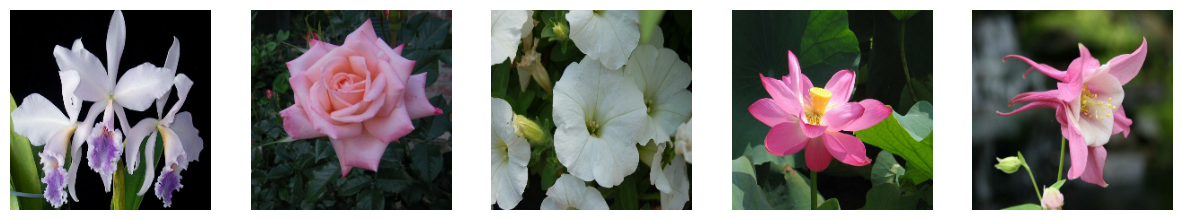

In [54]:
def show_batch_img(ds, n=5):

    for images in ds.take(1):
        fig, axes = plt.subplots(1, n, figsize=(15, 5))
        for i in range(n):
            idx = np.random.randint(images.shape[0])  # случайный индекс внутри батча
            axes[i].imshow(images[idx].numpy().astype("uint8"))  # если изображения 0-255
            axes[i].axis("off")
        plt.show()
        break

show_batch_img(train_ds, 5)

In [ ]:
# --- trnsfomation into gray with normalisation, cration structure: (input, target) ---

def transform_gray(ds):
    def to_gray(image):
        image = tf.cast(image, tf.float32) / 255.0
        gray  = tf.image.rgb_to_grayscale(image)
        return gray, image   # (input, target)

    ds_gray = ds.map(to_gray)
    ds_gray = ds_gray.cache().prefetch(tf.data.AUTOTUNE)
    return ds_gray



In [ ]:
def show_gray_img(ds, n=5):


    for x_batch, y_batch in ds.take(1):
        fig, axes = plt.subplots(2, n, figsize=(15, 6))
        batch_size = x_batch.shape[0]

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- grayscale (input) ---
            axes[0, i].imshow(tf.squeeze(x_batch[idx]), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Input (Gray)')

            # --- RGB (target) ---
            axes[1, i].imshow(tf.cast(y_batch[idx]*255, tf.uint8))
            axes[1, i].axis('off')
            axes[1, i].set_title('Target (RGB)')

        plt.show()
        break

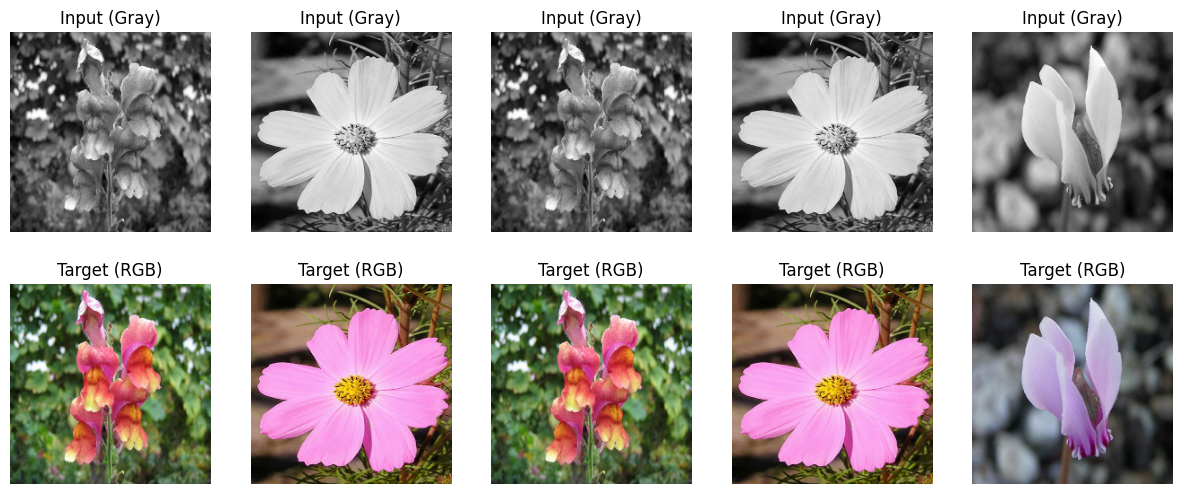

In [ ]:
# --- trnsfomation into gray with normalisation, cration structure: (input, target) ---
train_gray_ds = transform_gray(train_ds)
val_gray_ds = transform_gray(val_ds)
show_gray_img(train_gray_ds, n=5)


### --- Model ---

In [97]:
# --- input ---
input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1))  # grayscale

# --- encoder ---
x = Conv2D(64, 3, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)

# --- decoder ---
x = UpSampling2D((2,2))(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)

x = UpSampling2D((2,2))(x)

# --- output ---
output_img = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# --- model ---
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

In [99]:
# --- autoencoder fitting ---

autoencoder.fit(
    train_gray_ds,          # ВХОД → grayscale
    epochs=10,
    validation_data=val_gray_ds  # Валидация
)

Epoch 1/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - loss: 0.0228 - val_loss: 0.0198
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - loss: 0.0193 - val_loss: 0.0192
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - loss: 0.0188 - val_loss: 0.0189
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - loss: 0.0185 - val_loss: 0.0186
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - loss: 0.0184 - val_loss: 0.0183
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - loss: 0.0183 - val_loss: 0.0182
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - loss: 0.0182 - val_loss: 0.0181
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - loss: 0.0180 - val_loss: 0.0179
Epoch 9/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - loss: 0.0179 - val_loss: 0.0178
Epoch 10/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - loss: 0.0178 - val_loss: 0.0178


In [134]:
decoded_imgs = autoencoder.predict(train_gray_ds)

410/410 ━━━━━━━━━━━━━━━━━━━━ 134s 327ms/step


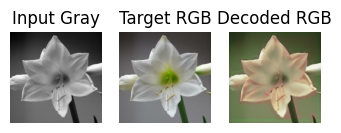

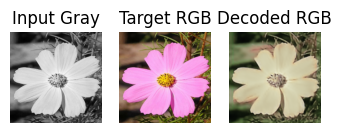

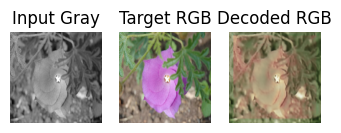

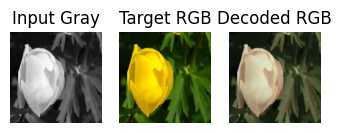

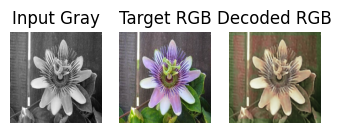

In [139]:
for i in range(5):
    plt.figure(figsize=(4,4))
    plt.subplot(1,3,1)
    plt.imshow(tf.squeeze(next(iter(train_gray_ds))[0][i]), cmap='gray')
    plt.title("Input Gray")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(next(iter(train_gray_ds))[1][i])
    plt.title("Target RGB")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(decoded_imgs[i])
    plt.title("Decoded RGB")
    plt.axis('off')
    plt.show()


